In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from tqdm import tqdm
%matplotlib inline
sns.set(font_scale=1.2, style = 'whitegrid', color_codes=True)

In [226]:
df = pd.read_csv('Twitter_EDA.csv')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255501 entries, 0 to 1255500
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   UserId           1255501 non-null  float64
 1   UserName         1255501 non-null  object 
 2   Verified         1255501 non-null  bool   
 3   Location         896371 non-null   object 
 4   Followers        1255501 non-null  float64
 5   Tweet            1255501 non-null  object 
 6   Language         1255501 non-null  object 
 7   Date             1255501 non-null  object 
 8   Time_of_the_day  1255501 non-null  object 
dtypes: bool(1), float64(2), object(6)
memory usage: 77.8+ MB


In [46]:
df.shape

(1255501, 9)

# Data Wrangling and EDA

**Get country information from the location column**

In [517]:
df['Location'].fillna(value='Unknown',inplace=True)

In [48]:
#!pip install geopy

In [518]:
# Assign unkown location's country to "Unknonwn"
df.loc[df['Location']=='Unknown','Country'] = 'Unknown'

In [50]:
def get_country(location):
    if location == 'Unknown':
        return "Unknown"
    else:
        try:
            loc = locator.geocode(location)
            if loc:
                country = loc.raw['display_name'].split(',')[-1].strip()
                return country
            else:
                return "Unknown"
        except:
            return "Unknown"

In [74]:
tqdm.pandas() # display a progress bar for the apply function
df.loc[100:10000,'Country'] = \
df.loc[100:10000, 'Location'].progress_apply(lambda x: get_country(x))  #apply function with progress bar using tqdm.pandas()

100%|████████████████████████████████████████████████████████████████████████████| 9901/9901 [1:03:50<00:00,  2.58it/s]


The above progress shows an estimate of over 1hour for processing 10000 items. To improve the speed of process:
- cache the results 
- batch process
- parallel processing

In [51]:
import time
import os
import pickle
import concurrent.futures
from geopy.geocoders import Nominatim

In [511]:
#create a geolocation object
locator = Nominatim(user_agent = 'myGeocoder')

#load or create cache for geocode results
CACHE_FILE = 'geocode_cache.pickle'
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, 'rb') as f:
        geocode_cache = pickle.load(f)
else:
    geocode_cache = {}
    geocode_cache['Unknown'] = 'Unknown'

print(len(geocode_cache))

32588


In [13]:
# define a function to extract the country fromm the location column
def get_country(location):
    # check if geocode result is in cache
      if location in geocode_cache:
          return geocode_cache[location]
      else:
          try:
              loc = locator.geocode(location)
              if loc:
                  country = loc.raw['display_name'].split(',')[-1].strip()
                  # Add location to cache if not in cache
                  geocode_cache[location] = country
                  return country
              else:
                  return "Unknown"
          except:
              return "Unknown"

In [41]:
#define a function to process locations in batches using parallel processing
def process_locations(df, max_workers, batch_size=100):
    locations = df['Location'].to_list()
    n = len(locations)
    country_list = ['Unknown']*n
    
    #split the locations into batches (tuples, with start index)
    batches = [(i, locations[i:i+batch_size]) for i in range(0, n, batch_size)]
    
    #process each batch in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers = max_workers) as executor:
        future_to_batch = {executor.submit(process_batch, idx, batch):batch for idx, batch in batches}
        for future in tqdm(concurrent.futures.as_completed(future_to_batch), total=len(future_to_batch)):
            start_index, batch_result = future.result()
            for i, country in enumerate(batch_result):
                idx = i + start_index
                if idx <n:
                    country_list[idx] = country
    #store the geocode cache to file
    with open(CACHE_FILE, 'wb') as f:
        pickle.dump(geocode_cache, f)
    
    return country_list


In [15]:
#define a function to process a single batch of locations
def process_batch(start_idx, batch):
    batch_result = [get_country(location) for location in batch]
    return start_idx, batch_result

In [24]:
df_2 = df[0:10000].copy()

In [26]:
df_2['Country']=process_locations(df_2)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [36:17<00:00, 21.78s/it]


The speed of geocoding has been improved by 43%. Apply this method to retrieve the country for the rest of the table and save the cache.

In [713]:
df_1 = df.copy()

#map the values in 'location' column to the corresponding country using the geocode_cache file
df_1['Country'] = df_1['Location'].map(geocode_cache)
df_1['Country'] = df_1['Country'].fillna('Unknown')
df_1['Country'].value_counts()

Unknown                                            585879
United States                                      212293
United Kingdom                                      47998
India                                               41998
日本                                                  40351
                                                    ...  
Astralhytten                                            1
812                                                     1
Jadransko more / Mare Adriatico / Deti Adriatik         1
Ascension and Tristan da Cunha                          1
Tonga                                                   1
Name: Country, Length: 246, dtype: int64

In [742]:
#replace the collected country name with the english name using a country:country_eng_name dictionary
with open('country.pickle', 'rb') as f:
    country_dict = pickle.load(f)
df_1['Country_name']=df_1['Country'].map(country_dict).fillna(df_1['Country'])
df_1=df_1.drop(columns=['Country'])

In [744]:
df_1=df_1.rename(columns={'Country_name':'Country'})

In [870]:
#Get the top 10 country that discuss about ChatGPT most often (except 'Unknown')
df_country = pd.DataFrame(df_1[df_1['Country']!='Unknown']['Country'].value_counts())
df_country=df_country.reset_index()
df_country = df_country.rename(columns={'index':'Country','Country':'Count'})
total = df_country['Count'].sum()
df_country['Percentage']=round(df_country['Count']/total*100,1)
df_country[0:10]

,Country,Count,Percentage
0,United States of America,212293,31.7
1,United Kingdom,47998,7.2
2,India,41998,6.3
3,Japan,40351,6.0
4,France,35952,5.4
5,Canada,30600,4.6
6,Germany,23857,3.6
7,Spain,22568,3.4
8,Australia,15045,2.2
9,Brazil,13359,2.0


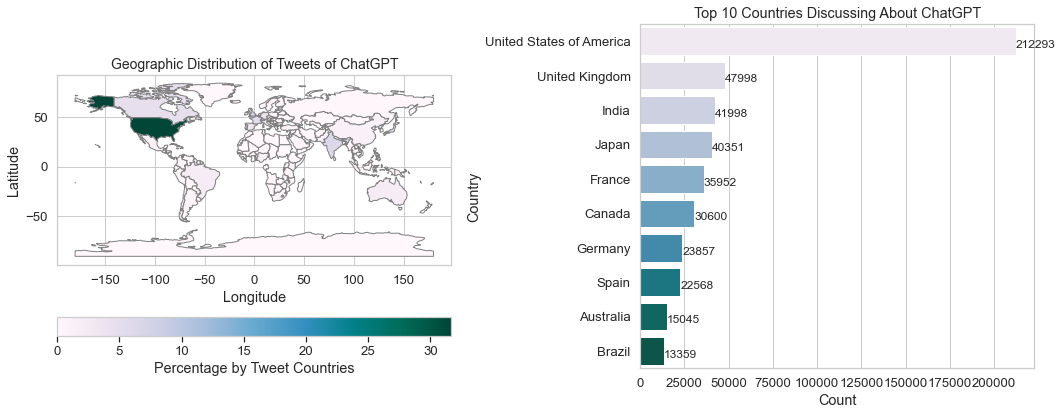

In [880]:
#!pip install geopandas
import geopandas as gpd

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Merge the country data onto the GeoDataFrame
world = world.merge(df_country, left_on='name', right_on='Country', how='left')
#plot
fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.subplot(1,2,1)
ax=world.plot(column='Percentage', cmap='PuBuGn', legend=True, 
              legend_kwds={'label': "Percentage by Tweet Countries",'orientation':'horizontal'},
              figsize=(10,6),linewidth=1, edgecolor='0.5', ax=ax[0])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geographic Distribution of Tweets of ChatGPT',size=14)

plt.subplot(1,2,2)
ax = sns.barplot(y=df_country['Country'][0:10], x=df_country['Count'][0:10], palette = 'PuBuGn')
ax.set_title('Top 10 Countries Discussing About ChatGPT')
for p in ax.patches:
    ax.text(p.get_width(), p.get_y()+0.5, int(p.get_width()), va='center', size=12)
plt.tight_layout()
plt.show()

- 31.7% users tweeting about ChatGPT are from the U.S.
- The top 5 countries discuss about ChatGPT the most are: America, United Kingdom, India, Japan, and France.
- People from all over 150 countries are talking about ChatGPT. 

In [881]:
world[world['Percentage'].notna()]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country,Count,Percentage
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,61.0,0.0
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,772.0,0.1
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,30600.0,4.6
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,212293.0,31.7
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,342.0,0.1
...,...,...,...,...,...,...,...,...,...
171,2083459.0,Europe,North Macedonia,MKD,12547,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",North Macedonia,118.0,0.0
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",Serbia,498.0,0.1
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",Montenegro,59.0,0.0
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Kosovo,126.0,0.0


In [746]:
df['Country'] = df_1['Country'].copy()
df['Country'].value_counts()

Unknown                     585879
United States of America    212293
United Kingdom               47998
India                        41998
Japan                        40351
                             ...  
90094                            1
San Marino                       1
Pitcairn Islands                 1
Astralhytten                     1
Tonga                            1
Name: Country, Length: 242, dtype: int64

**Tweets with time**

In [876]:
sns.choose_colorbrewer_palette('diverging')
colors = sns.set_palette('PuBuGn')
sns.set_palette('PuBuGn')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

In [747]:
from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the start date as the first day of the first week
start_date = pd.to_datetime('2022-12-01')

# Create a date range from the first day of the first week to January 31, 2023
dates = pd.date_range(start=start_date, end='2023-01-31')

#create a dictionary to store date-week
date_week = {}
for date in dates:
    week = date.isocalendar().week - start_date.isocalendar().week + 1
    if week < 0:
        week += 52
    date_week[date] = week

In [748]:
df['Week'] = df['Date'].map(date_week)
df['Week'] = df['Week'].astype('int')
df['Mon'] = df['Date'].dt.month_name()
df['Month'] = df['Mon'].map({'January': "January,2023", 'December': 'December,2022'})
df = df.drop('Mon', axis=1)

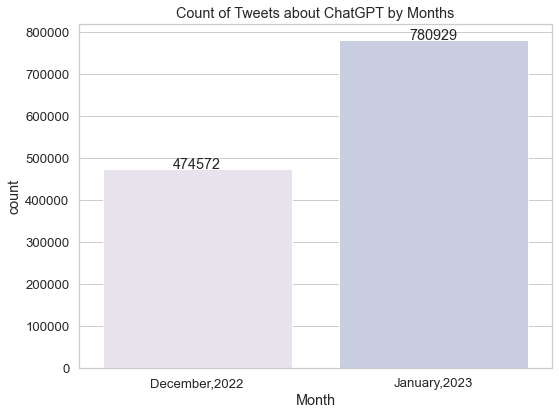

The tweets about ChatGPT in January, 2023 is 1.65 times of the tweets amount in December, 2022.


In [749]:
#Count by Month
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.countplot(x=df['Month'], order = ['December,2022', 'January,2023'])
for p in ax.patches:
    ax.text(p.get_width()/2 + p.get_x(), p.get_height()+1000, p.get_height(), horizontalalignment='center')
ax.set_title('Count of Tweets about ChatGPT by Months')
plt.tight_layout()
plt.show()

times = round(df['Month'].value_counts()[0]/df['Month'].value_counts()[1],2)
print(f'The tweets about ChatGPT in January, 2023 is {times} times of the tweets amount in December, 2022.')

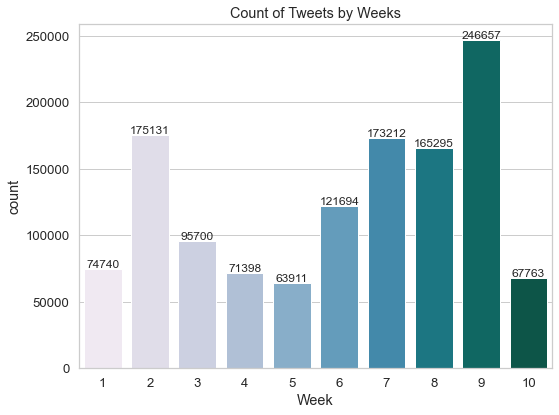

In [750]:
#Count by Week
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.countplot(x=df['Week'], palette='PuBuGn')
for p in ax.patches:
    ax.text(p.get_width()/2 + p.get_x(), p.get_height()+1000, p.get_height(), horizontalalignment='center', size =12)
ax.set_title('Count of Tweets by Weeks')
plt.tight_layout()
plt.show()

- There was a wide discussion about ChatGPT once it released, nearly 250,000 tweets in the first two weeks (till 2022-12-11). 
- The popularity of ChatGPT topics decreased gradually from the Week 3 till Week 5.
- Start from Week 6 (2023-01-02), the trend of discussing ChatGPT showed significant increase.
- In week 9, the discussion about ChatGPT reached the maximum (246657) in the two months, the decrease count in week10 is due to only 2 days data were collected. 

**User Features**

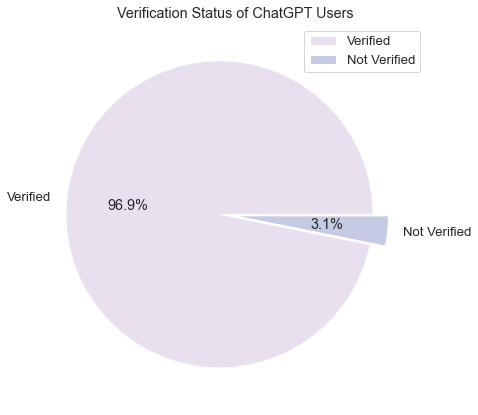

In [760]:
#Verification Status
fig,ax=plt.subplots(1,1,figsize=(8,6))
pie = df['Verified'].value_counts()
plt.pie(pie, autopct="%.1f%%", labels = ['Verified', 'Not Verified'], explode=[0.1,0])
ax.set_title('Verification Status of ChatGPT Users')
plt.legend()
plt.tight_layout()
plt.show()

- Only 3.1% of ChatGPT users are verified Twitter users. 
- ChatGPT is not confined only to verified users, it is widely adopted across all Twitter users

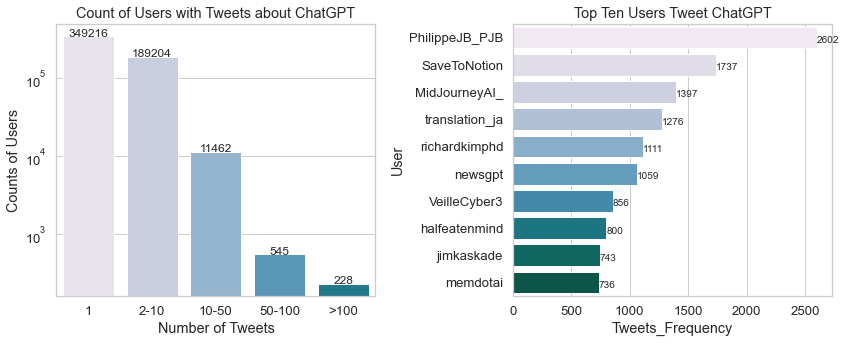

In the past two months (Dec 2022 and Jan 2023),there are a total of 550655 twitter users tweeted about ChatGPT. 
63.42% users have tweeted only once, while 36.58% users have tweeted more than once.


In [762]:
#Tweets frequency
df_user = pd.DataFrame(df["UserName"].value_counts())
df_user=df_user.reset_index()
df_user = df_user.rename(columns={'index':'User', 'UserName':"Tweets_Frequency"})
bins = [0, 1, 10, 50, 100, df_user["Tweets_Frequency"].max()]
labels=['1', '2-10', '10-50', '50-100', '>100' ]
df_user['Level'] = pd.cut(df_user['Tweets_Frequency'], bins = bins, labels =  labels)
df_user["Level"].value_counts()

fig,ax = plt.subplots(1,2, figsize=(12,5))
plt.subplot(1,2,1)
ax= sns.barplot(x=df_user['Level'].value_counts().index, y = df_user['Level'].value_counts())
ax.set_ylabel('Counts of Users')
ax.set_xlabel('Number of Tweets')
ax.set_title('Count of Users with Tweets about ChatGPT')
for p in ax.patches:
    ax.text(p.get_width()/2+p.get_x(), p.get_height(), int(p.get_height()), ha='center', size=12)
ax.set_yscale('log')

plt.subplot(1,2,2)
ax = sns.barplot(y = df_user['User'][0:10], x=df_user['Tweets_Frequency'][0:10], palette='PuBuGn')
for p in ax.patches:
    ax.text(p.get_width(), p.get_y()+0.5, int(p.get_width()), va='center', size=10)
ax.set_title('Top Ten Users Tweet ChatGPT')
plt.tight_layout()
plt.show()

total = df_user.shape[0]
once = round(df_user[df_user['Level']=='1'].shape[0]/total*100,2)
print(f'In the past two months (Dec 2022 and Jan 2023),there are a total of {total} \
twitter users tweeted about ChatGPT. \n{once}% users have tweeted only once, while {100-once}% users have tweeted more than once.')

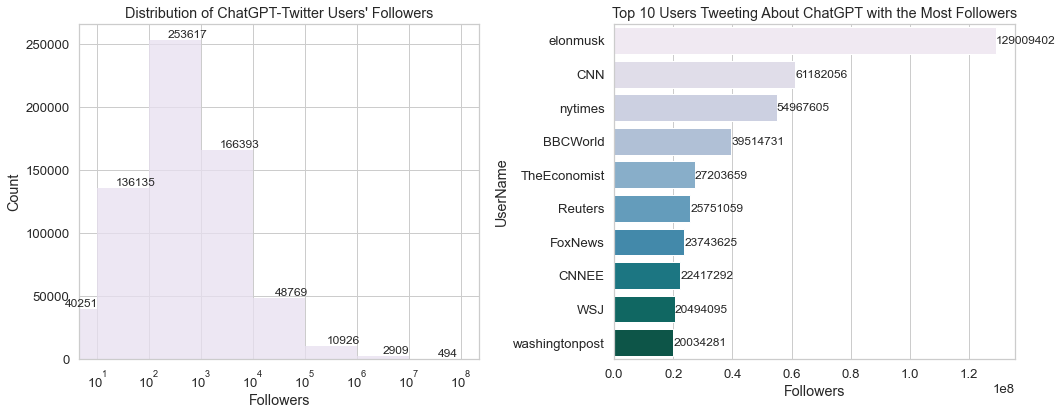

In [883]:
#Followers
fig,ax= plt.subplots(1,2,figsize=(15,6))
#followers distribution
plt.subplot(1,2,1)
bins = [0, 10, 100, 1000, 1e4, 1e5, 1e6,1e7,1e8]
ax = sns.histplot(df['Followers'], bins=bins)
ax.set_xscale('log')
ax.set_title("Distribution of ChatGPT-Twitter Users' Followers")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),ha='center',va='bottom',size=12)

#Top 10 Users
plt.subplot(1,2,2)
df_fo=df[['UserName', 'Followers']]
df_fo=df_fo.sort_values('Followers', ascending=False)
df_fo = df_fo.drop_duplicates(subset=['UserName'], keep='first')
ax = sns.barplot(y=df_fo['UserName'][0:10], x=df_fo['Followers'][0:10], palette='PuBuGn')
ax.set_title('Top 10 Users Tweeting About ChatGPT with the Most Followers')
for p in ax.patches:
    ax.annotate(int(p.get_width()), (p.get_width(), p.get_y()+0.5), size=12)
plt.tight_layout()
plt.show()

- Most users tweeting about ChatGPT have followers between 0-10000.
- Some popular Twitter users with followers over millions also care about ChatGPT, such as (elonmusk, CNN, NYTimes, etc.)

In [858]:
df_fo=df[['UserName', 'Followers']]
df_fo=df_fo.sort_values('Followers', ascending=False)
df_fo = df_fo.drop_duplicates(subset=['UserName'], keep='first')
df_fo[0:10]

,UserName,Followers
1246569,elonmusk,129009402
297961,CNN,61182056
468705,nytimes,54967605
290706,BBCWorld,39514731
777025,TheEconomist,27203659
630774,Reuters,25751059
678437,FoxNews,23743625
478176,CNNEE,22417292
602834,WSJ,20494095
409592,washingtonpost,20034281


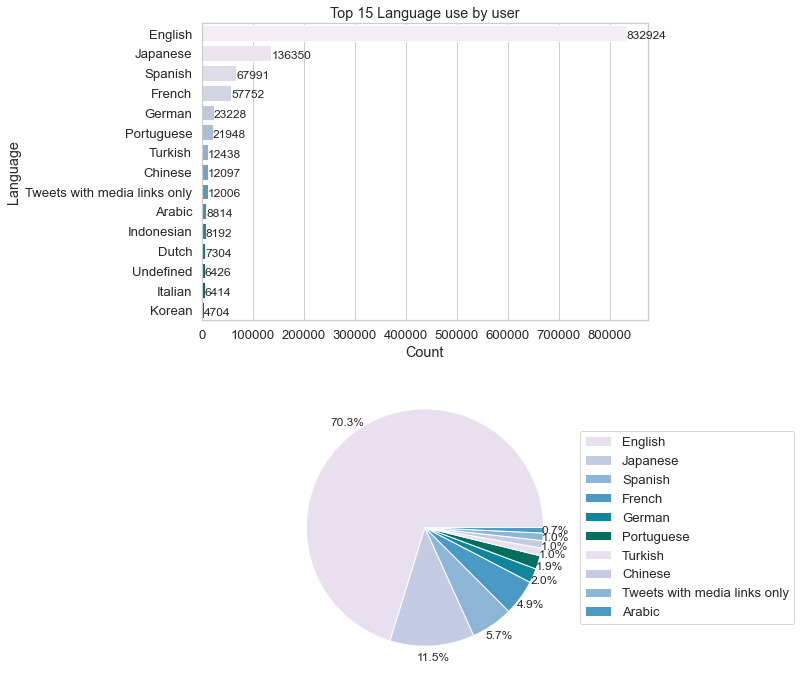

In [763]:
#Language

#!pip install langcodes[data]
import langcodes
#Prepare a dictionary with language code: language names
codes = list(df_lan['Lan'].unique())
language_dict = {code: langcodes.Language.make(code).language_name() for code in codes}
language_dict['qam']='Tweets with mentions only'
language_dict['qme']='Tweets with media links only'
language_dict['qht']='Tweets with hashtags only'
language_dict['und']='Undefined'

df_lan = pd.DataFrame(df['Language'].value_counts())
df_lan = df_lan.reset_index()
df_lan = df_lan.rename(columns = {'index':"Lan", "Language": 'Count'})
df_lan['Language'] = df_lan['Lan'].map(language_dict)


fig, ax = plt.subplots(2,1,figsize=(8,12))
plt.subplot(2,1,1)
ax = sns.barplot(y=df_lan['Language'][0:15], x=df_lan['Count'], palette='PuBuGn')
for p in ax.patches:
    ax.text(p.get_width(), p.get_y()+0.5, int(p.get_width()), va='center',size=12)
ax.set_title('Top 15 Language use by user')

plt.subplot(2,1,2)
plt.pie(df_lan['Count'][0:10], autopct='%.1f%%', pctdistance = 1.1, textprops={'fontsize':12})
plt.legend(bbox_to_anchor=(1,0.5), labels=df_lan['Language'][0:10], loc='center left')
plt.show()

- Most users (over 70%) that discussed about ChatGPT are English speakers
- 30% of tweets are written in other languages, i.e. Japanese, Spanish, French, etc. This indicates that ChatGPT is also able to function in other languages. 

In [765]:
df.to_csv('Twitter_EDA_clean.csv')